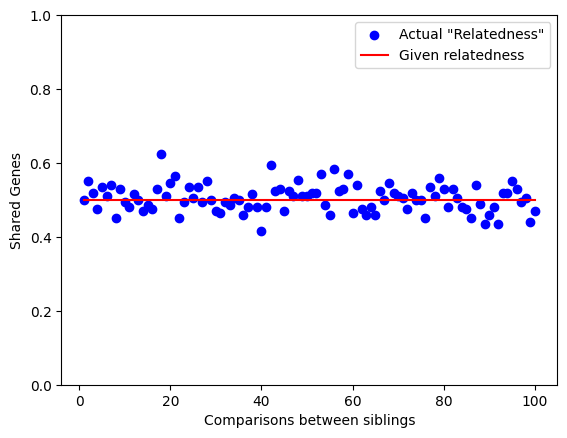

In [ ]:
import random
import matplotlib.pyplot as plt

def create_organism(n):
    """Creates a diploid organism with 100 genes, each having two alleles."""
    return [[2*(i+n),(2*(i+n)) + 1 ] for i in range(100)]

def create_offspring(parent_a, parent_b):
    """Creates an offspring by inheriting one allele from each parent per gene."""
    return [
        [random.choice(parent_a[i]), random.choice(parent_b[i])]
        for i in range(100)
    ]

def count_matching_alleles(offspring1, offspring2):
    """Counts the number of identical alleles between two offspring."""
    match_count = sum(
        1 for i in range(100) for j in range(2) if offspring1[i][j] == offspring2[i][j]
    )
    return match_count

# Create parent organisms
parent_A = create_organism(0)
parent_B = create_organism(300)

# Create two offspring
offspring1 = create_offspring(parent_A, parent_B)

x = []
y = []
z = []
for i in range (100):
	offspring2 = create_offspring(parent_A, parent_B)
	matching_alleles = count_matching_alleles(offspring1, offspring2)
	x.append(i+1)
	y.append(matching_alleles/200)
	z.append(0.5)

plt.scatter(x,y,color='blue', label='Actual "Relatedness"')
plt.plot(x,z, color='red', label='Given relatedness')
plt.xlabel('Comparisons between siblings')
plt.ylabel('Shared Genes')
plt.ylim(0, 1)
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt

# Define the Graph Neural Network
class GNNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GNNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, graph, features):
        h = torch.zeros_like(features)
        for node in graph.nodes():
            neighbor_feats = torch.stack([features[neighbor] for neighbor in graph.neighbors(node)], dim=0)
            if neighbor_feats.size(0) > 0:
                h[node] = neighbor_feats.mean(dim=0)
        h = self.linear(h)
        return F.relu(h)

class RelatednessGNN(nn.Module):
    def __init__(self, in_feats, hidden_feats, num_layers):
        super(RelatednessGNN, self).__init__()
        self.embedding = nn.Embedding(100, in_feats)  # assuming max 100 nodes
        self.layers = nn.ModuleList([
            GNNLayer(in_feats if i == 0 else hidden_feats, hidden_feats) for i in range(num_layers)
        ])

    def forward(self, graph, node_pairs):
        h = self.embedding(torch.arange(graph.number_of_nodes()))

        for layer in self.layers:
            h = layer(graph, h)

        results = []
        for u, v in node_pairs:
            score = torch.sigmoid(torch.dot(h[u], h[v]))
            paths = self.find_paths(graph, u, v)
            weighted_paths = self.weight_paths(paths, h)
            results.append((score, weighted_paths))

        return results

    def find_paths(self, graph, start, end, path=[]):
        path = path + [start]
        if start == end:
            return [path]
        if start not in graph:
            return []
        paths = []
        for node in graph.neighbors(start):
            if node not in path:
                newpaths = self.find_paths(graph, node, end, path)
                for newpath in newpaths:
                    paths.append(newpath)
        return paths

    def weight_paths(self, paths, embeddings):
        weighted = []
        for path in paths:
            if len(path) < 2:
                continue
            weight = 0.0
            for i in range(len(path) - 1):
                weight += torch.dot(embeddings[path[i]], embeddings[path[i + 1]]).item()
            weighted.append((path, weight))
        weighted.sort(key=lambda x: x[1], reverse=True)
        return weighted

# Example graph and data
graph = nx.Graph()
graph.add_edges_from([
    (0, 1), (1, 2), (1, 3), (3, 4), (2, 4), (4, 5), (5, 6), (5, 7)
])

node_pairs = [(0, 6), (2, 7)]
true_relatedness = torch.tensor([0.8, 0.6])  # hypothetical ground truth

# Training function
def train(model, graph, node_pairs, true_relatedness, epochs=100, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(graph, node_pairs)

        pred_scores = torch.stack([score for score, _ in predictions])
        loss = criterion(pred_scores, true_relatedness)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Initialize and train model
model = RelatednessGNN(in_feats=16, hidden_feats=32, num_layers=2)
train(model, graph, node_pairs, true_relatedness)

# Inference
def infer(model, graph, node_pairs):
    with torch.no_grad():
        results = model(graph, node_pairs)
        for (u, v), (score, paths) in zip(node_pairs, results):
            print(f"Relatedness between {u} and {v}: {score.item():.3f}")
            print("Top paths:")
            for path, weight in paths[:3]:
                print(f"  Path: {path}, Weight: {weight:.3f}")

infer(model, graph, node_pairs)


Epoch 0, Loss: 0.0226
Epoch 10, Loss: 0.0022
Epoch 20, Loss: 0.0009
Epoch 30, Loss: 0.0003
Epoch 40, Loss: 0.0001
Epoch 50, Loss: 0.0000
Epoch 60, Loss: 0.0000
Epoch 70, Loss: 0.0000
Epoch 80, Loss: 0.0000
Epoch 90, Loss: 0.0000
Relatedness between 0 and 6: 0.800
Top paths:
  Path: [0, 1, 2, 4, 5, 6], Weight: 3.094
  Path: [0, 1, 3, 4, 5, 6], Weight: 3.094
Relatedness between 2 and 7: 0.600
Top paths:
  Path: [2, 1, 3, 4, 5, 7], Weight: 1.861
  Path: [2, 4, 5, 7], Weight: 0.537


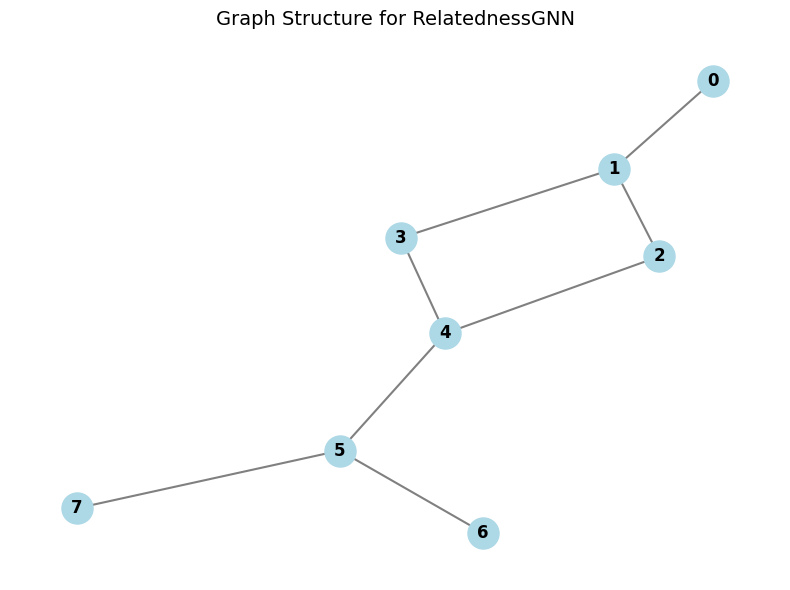

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the graph (same as in your code)
graph = nx.Graph()
graph.add_edges_from([
    (0, 1), (1, 2), (1, 3), (3, 4), (2, 4), (4, 5), (5, 6), (5, 7)
])

# Set up the plot
plt.figure(figsize=(8, 6))

# Choose a layout (Spring layout is good for small graphs)
pos = nx.spring_layout(graph, seed=42)  # seed for reproducibility

# Draw nodes and edges
nx.draw_networkx_nodes(graph, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_edges(graph, pos, width=1.5, edge_color='gray')

# Add node labels
nx.draw_networkx_labels(graph, pos, font_size=12, font_weight='bold')

# Add title and remove axis
plt.title("Graph Structure for RelatednessGNN", fontsize=14)
plt.axis('off')  # Turn off axis

# Show the plot
plt.tight_layout()
plt.show()